In [1]:
from ipywidgets import interact
import ipywidgets as widgets
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [2]:
fs, p = wavfile.read('sonido-presion/presion_segmento_2.wav')
fs, y = wavfile.read('sonido-presion/y_segmento_2.wav')
fs, b = wavfile.read('sonido-presion/beta_segmento_2.wav')
fs, s_m = wavfile.read('sonido-presion/sonido_segmento_2.wav')
fs, delta = wavfile.read('sonido-presion/delta1_segmento_2.wav')
fs, delta2 = wavfile.read('sonido-presion/delta2_segmento_2.wav')
fs, k = wavfile.read('sonido-presion/k_segmento_2.wav')
fs, vs = wavfile.read('sonido-presion/vs_segmento_2.wav')

y = y[:-1]
b = b[:-1]
k = k[:-1]


In [3]:
import json
file_fon = open('sonido-presion/t_fon_segmento_2.json') 
t_silabas_file = open('sonido-presion/t_silabas.json') 

# returns JSON object as a list 
t_silabas = json.load(t_silabas_file)['segmento_2']
t_fonacion = json.load(file_fon) 

Este diccionario es importante porque marca los tiempos donde está prendicio delta y k. Así va hacer más fácil encotnrar la relación entre k,delta y vs

In [4]:

dt = 1/fs
N  = len(p)
t = np.arange(0, N) * dt

print(f'frec muestreo: {fs} \n dt muestreo: {dt} \n tiempo total de medición {t[-1]} s')

frec muestreo: 44150 
 dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.9829898074745187 s


In [5]:
print(len(p), len(y), len(b), len(s_m), len(delta), len(k))

43400 43400 43400 43400 43400 43400


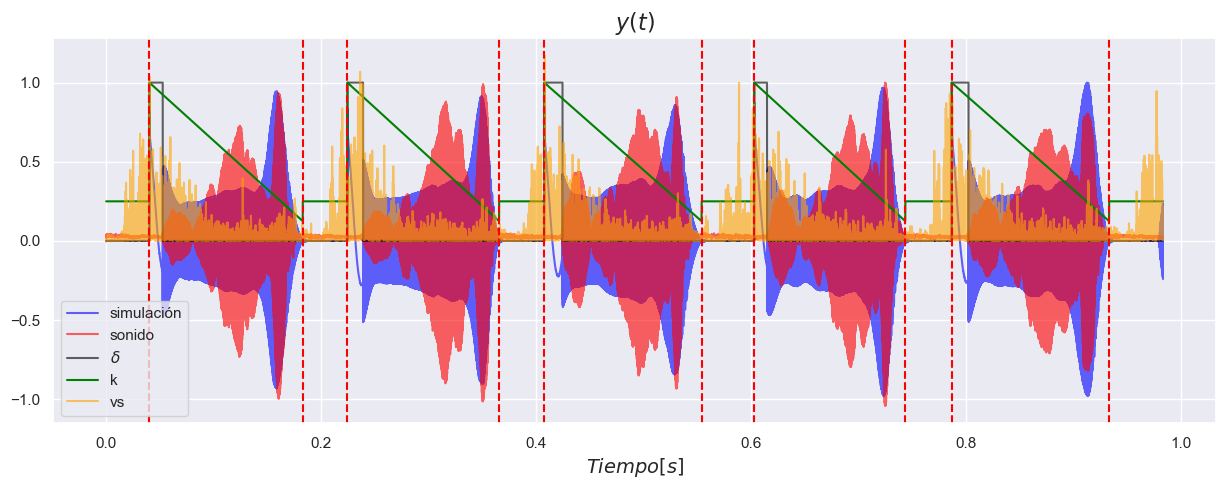

In [6]:
%matplotlib inline
plt.figure( figsize=(15,5))
#ploteo
colors = ['green','red','black','blue']

plt.plot(t, y/max(y),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t, s_m/max(s_m) ,alpha = .60, color='red', label = r'sonido')
#plt.plot(t, b, alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t, delta, alpha = .60, color=colors[2], label = r'$\delta$')
plt.plot(t, k/max(k), color = 'green', label = 'k')
plt.plot(t, np.abs(vs)/max(vs), alpha = .6, color = 'orange', label = 'vs')
#plt.plot(t, (delta_interp  + ruido) * f0, alpha = .6, color = colors[2], label = r'$\delta$')
for i,ps in enumerate(t_silabas):
    t_i = t_silabas[ps]['t_i']
    t_f = t_silabas[ps]['t_f']
    plt.axvline(t_i, ls= '--', color = 'red')
    plt.axvline(t_f, ls = '--', color = 'red')
plt.legend(loc=0)
#plt.xlim(0,0.4)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$y(t)$', fontsize=16)
plt.show()

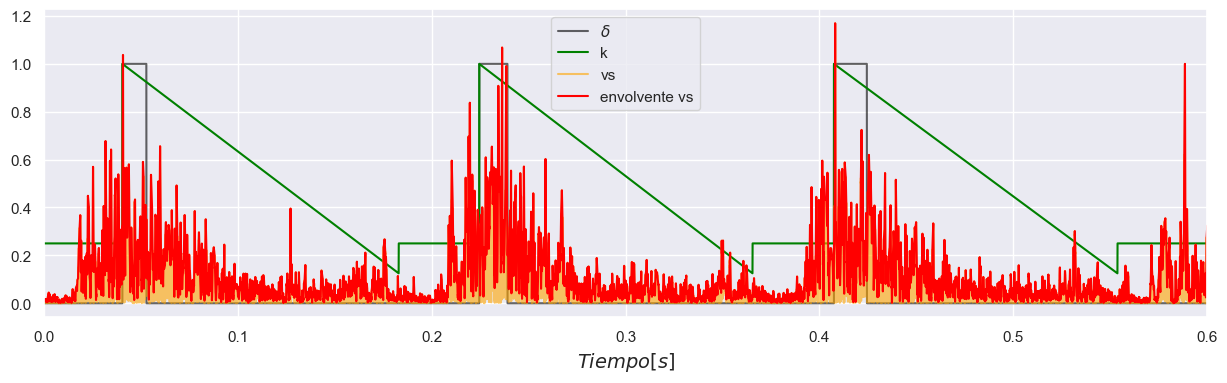

In [7]:
picos_vs, _ = signal.find_peaks(np.abs(vs), height = 0 )  

plt.figure( figsize=(15,4))
#ploteo
colors = ['green','red','black','blue']

plt.plot(t, delta, alpha = .60, color=colors[2], label = r'$\delta$')
plt.plot(t, k/max(k), color = 'green', label = 'k')
plt.plot(t, abs(vs)/max(vs), alpha = .6, color = 'orange', label = 'vs')
plt.plot(t[picos_vs], np.abs(vs[picos_vs])/max(vs), color = 'red', label = 'envolvente vs')
plt.legend(loc=0)
plt.xlim(0,0.6)
plt.xlabel('$Tiempo [s]$', fontsize=14)
#plt.title(r'$y(t)$', fontsize=16)
plt.show()

### Cálculo de la envolvente g(EMG)

$$
\dot{g} = \frac{1}{\tau} (-g + vs(t))
$$

In [8]:

#funcion del sistema de ecuaciones
def f(x, t, params):

    tau, vs = params

    f_x = 1/tau * (-x + vs)
    return f_x

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [9]:
print(len(t) , len(vs), len(Xs))

NameError: name 'Xs' is not defined

In [10]:

def plot1(tau):
    N = len(t)
    
    tau = tau * 1e-2
    #condiciones iniciales
    x0 = np.abs(vs[0])
    Xs = np.zeros(N)
    Xs[0] = x0
    
    for j in range(N-1):
        #print(j)
        params = [tau, np.abs(vs[j])]
        paso = paso_RK(Xs[j], f, t[j], dt, params, 4)
        Xs[j + 1] = paso

    mean_silencios_env = np.mean(Xs[k==1]/max(Xs))
    mean_silencios_vs = np.mean(np.abs(vs)/max(vs))
    plt.figure(figsize = (15,4))
    plt.title('vs segmento 2')
    plt.plot(t,np.abs(vs)/max(vs), label = 'vs')
    plt.plot(t,Xs/max(Xs), label = 'vs envelope')
    #plt.plot(t, k/max(k), color = 'green', label = 'k')
    #plt.plot(t, delta/max(delta), color = 'black', label = 'delta')
    plt.plot(t, delta2/max(delta2), color = 'black', label = 'delta')
    """
    for i,ps in enumerate(t_silabas):
        t_i = t_silabas[ps]['t_i']
        t_f = t_silabas[ps]['t_f']
        plt.axvline(t_i, color = 'red', ls= '--')
        plt.axvline(t_f, color = 'red', ls= '--')
    """
    #plt.axhline(mean_silencios_env, color = 'black' ,label = f'<silencios> envolvente = {np.round(mean_silencios_env, 4)} \n')
    #plt.axhline(mean_silencios_vs, color = 'red', label = f'<silencios> vs = {np.round(mean_silencios_vs,4)} \n')
    plt.xlim(0,0.95)
    plt.xlabel('tiempo')
    plt.legend()
    plt.show()


#params
tau = widgets.FloatSlider(value=10e-1 , min= 1e-2 , max= 10, step= 1e-2, description='tau')

# linkeo el slider con los graficos
output1 = widgets.interactive_output(plot1, {'tau': tau})

# muestro los outputs#
display(tau, output1)


FloatSlider(value=1.0, description='tau', max=10.0, min=0.01, step=0.01)

Output()

como criterio para elegir el $\tau$ lo que voy a hacer es calcular los valores medios de los silencios de cada silaba y ver la tendencia. La idea es verificar que la integración no sea lo suficientemente gruesa como para ir subiendo los silencios.

In [11]:

def plot1(tau):
    N = len(t)
    
    tau = tau * 1e-2
    #condiciones iniciales
    x0 = np.abs(vs[0])
    Xs = np.zeros(N)
    Xs[0] = x0
    
    for j in range(N-1):
        #print(j)
        params = [tau, np.abs(vs[j])]
        paso = paso_RK(Xs[j], f, t[j], dt, params, 4)
        Xs[j + 1] = paso

    #plot valores medios
    mean_silencios_env = []
    mean_silencios = []
    plt.figure(figsize=(13,4))
    plt.plot(t, np.abs(vs)/max(vs))
    plt.plot(t, Xs/max(Xs), color = 'green')
    #plt.plot(t,k)
    for i,ps in enumerate(t_silabas):
        ts_fon = t_silabas[ps]
        if i == 0:
            t_i = 0
            t_f = ts_fon['t_i']
            t_i_prox = ts_fon['t_f']
        else:
            t_i = t_i_prox
            t_f = ts_fon['t_i']
            t_i_prox = ts_fon['t_f']
        #print(t_i,t_f)
        
        plt.plot(t[(t > t_i ) & (t < t_f )], np.abs(vs[(t > t_i ) & (t < t_f )])/max(vs), color = 'red')
        plt.plot(t[(t > t_i ) & (t < t_f )], Xs[(t > t_i ) & (t < t_f )]/max(Xs), color = 'orange')
        
        mean = np.mean(np.abs(vs[(t > t_i ) & (t < t_f )])/max(vs))
        mean_env = np.mean(Xs[(t > t_i ) & (t < t_f )]/max(Xs))
        mean_silencios_env.append(mean_env)
        mean_silencios.append(mean)
    #plt.xlim(0,0.8)
    plt.show()
    
    plt.figure(figsize=(10,4))
    plt.title('Valor medio de los silencios en cadsa pulso')
    plt.plot(mean_silencios, 'o', label = 'vs')
    plt.plot(mean_silencios_env, 'o', label = 'envolvente')
    plt.legend()
    plt.xlabel('pulso')
    plt.show()
#params
tau = widgets.FloatSlider(value=1e-1 , min= 1e-2 , max= 10, step= 1e-2, description='tau')

# linkeo el slider con los graficos
output1 = widgets.interactive_output(plot1, {'tau': tau})

# muestro los outputs#
display(tau, output1)


FloatSlider(value=0.1, description='tau', max=10.0, min=0.01, step=0.01)

Output()

### Elijo valor de $\tau$

In [12]:
tau = 1 * 1e-2 # es un tau razonable? no enceuntro un criterio cuantitativo. charlarlo con Gabo
#condiciones iniciales
x0 = np.abs(vs[0])
Xs = np.zeros(N)
Xs[0] = x0

for j in range(N-1):
    #print(j)
    params = [tau, np.abs(vs[j])]
    paso = paso_RK(Xs[j], f, t[j], dt, params, 4)
    Xs[j + 1] = paso

Ahora lo que quiero hacer calcular los valores de la envolvente que pasen el umbral. Donde al umbral lo voy a definir como cierto porcentaje del máximo de la señal

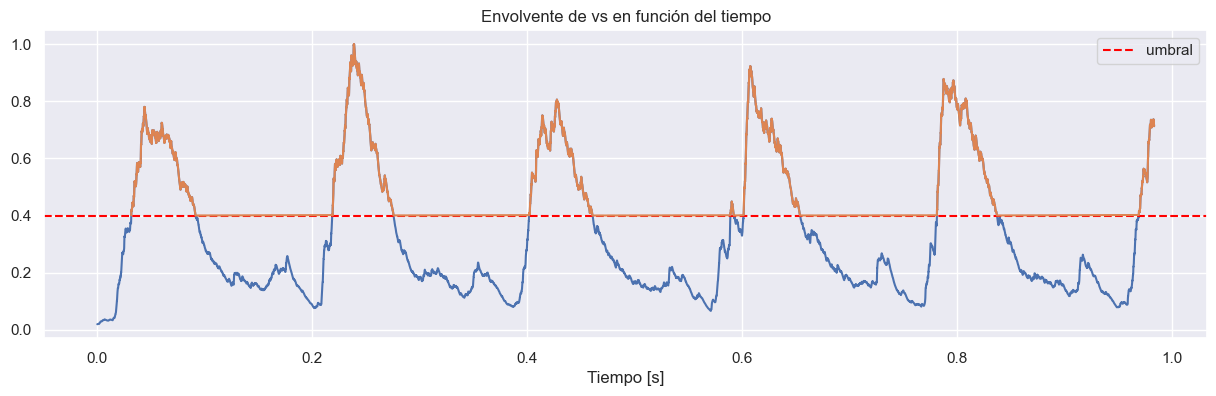

In [13]:
%matplotlib inline
plt.figure(figsize= (15,4))
env = Xs/max(Xs)
umbral = max(env) * .4
deltas = np.zeros(len(t))
deltas[env>umbral] = 1
plt.plot(t,env)
plt.axhline(umbral,ls = '--', color = 'red', label = 'umbral')
plt.plot(t[env>umbral], env[env>umbral])
#plt.plot(t,deltas, label = r'$\delta$ envolvente')
#plt.plot(t,delta, label = r'$\delta$ simulacion')
plt.xlabel('Tiempo [s]')
plt.title('Envolvente de vs en función del tiempo')
plt.legend()
plt.show()

### Determinación de umbral fino
Utilizar el mismo umbral para cada silaba nos define intervalos temporales que no reflejan bien la forma funcional de delta. Voy a definir un umbral  distinto para cada silaba

#### Discusión: con quécriterio defino el unmbral? 

El valor más chico posible tal que no pasen los valores del final?
El valor más grande tal que el intervalo sea mayor a delta? 

No convendría primero determinar el efecto de $k(t)$ en vs para sacar ese "ruido" y definir mejor $\delta$?

#### Utilizando el $\delta$2 puedo construir un criterio: que el umbral sea tal que pase la "cola" de la silaba con este delta encendido del final

#### Criterio que se me ocurre: que el umbral sea tal que maximice el overlap del delta predecido y el calculado con vs

In [30]:

def construir_delta2(xs, t, umbral, min_largo=50):
    delta2 = np.zeros(len(t)) #delta2 prelliminar
    dt = t[1] - t[0]
    t_delta = t[xs > umbral]
    xs_delta = xs[xs > umbral]

    
    #indices de los picos que pasan el umbral
    splits = np.where(np.diff(t_delta) > dt * min_largo)[0] + 1
    splits = np.split(t_delta, splits)
    #print(len(splits))
    for split in splits: #recorro cada intervalo que pasa el umbral
        if len(split) > min_largo:
            delta2[(t > split[0] ) & (t < split[-1] )] = 1

    return delta2



def solapamiento(delta1, delta2):
    return np.sum(delta1 * delta2)  # cantidad de posiciones donde ambos son 1

def penalidad(delta1, delta2):
    return np.sum(delta2 * (1 - delta1)) * .5 #PENALIZO MENOS POR CUANDO SE ALARGA EL INTERVALO
    
def score(delta1, delta2):
    return solapamiento(delta1, delta2) - penalidad(delta1, delta2)

def encontrar_mejor_umbral(xs, t, delta1, umbrales, min_largo=20):
    mejor_umbral = None
    mejor_delta2 = None
    mejor_score = -1

    for u in umbrales:
        delta2= construir_delta2(xs, t, u, min_largo)
        score_ = score(delta1, delta2)
        if score_ > mejor_score:
            mejor_score = score_
            mejor_umbral = u
            mejor_delta2 = delta2

    return mejor_umbral, mejor_delta2, mejor_score



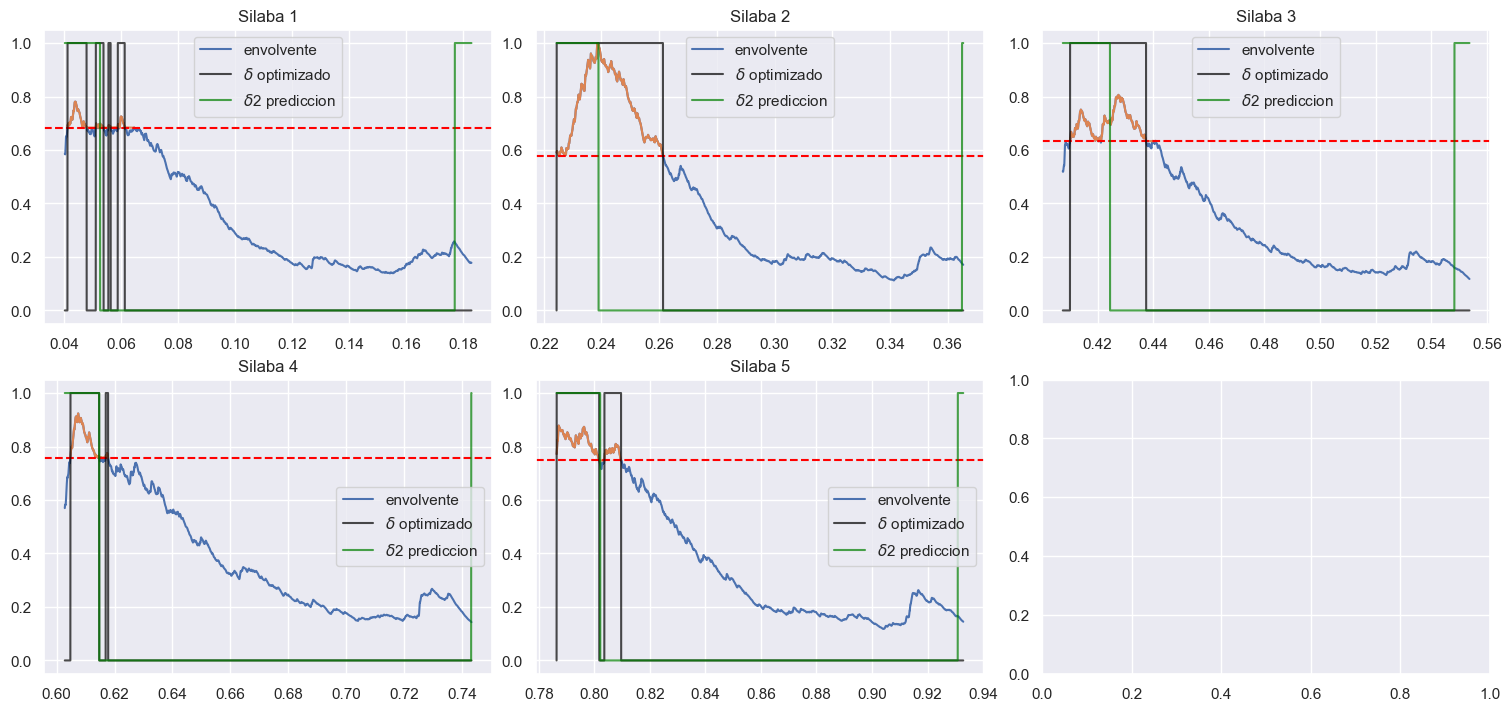

Porcentaje de solapamiento promedio sobre la predicción: 75.06824630150946 %
Porcentaje de excedente promedio sobre la optimización: 35.85655393677952 %


In [31]:
%matplotlib inline
fig, axes = plt.subplots(2, 3, figsize=(15,7), constrained_layout=True, sharey=False)
axs = axes.flatten()

ts_fon = t_silabas

delta_xs2 = np.zeros(len(t))

porcentajes_overlap = []
porcentajes_no_overlap = []
for i,ps in enumerate(ts_fon):
    t_i = ts_fon[ps]['t_i']
    t_f = ts_fon[ps]['t_f']
    t_ = t[(t > t_i ) & (t < t_f )]
    Xs_ = Xs[(t > t_i ) & (t < t_f )]/max(Xs)
    vs_ = np.abs(vs[(t > t_i ) & (t < t_f )])
    #delta_ = delta[(t > t_i ) & (t < t_f )]
    delta1_ = delta2[(t > t_i ) & (t < t_f )]
  
    #umbral para determinar delta
    umbrales = np.linspace(np.min(Xs_), np.max(Xs_), 100)
    umbral_opt, delta2_opt, score_ = encontrar_mejor_umbral(Xs_,t_, delta1_, umbrales, min_largo=20)
    delta_xs2[(t > t_i ) & (t < t_f )] = delta2_opt

    #overlap
    overlap = solapamiento(delta1_ , delta2_opt)
    porcentaje_overlap = overlap/ len(delta1_[delta1_>0])
    porcentajes_overlap.append(porcentaje_overlap)
    #exceso de delta
    sobra = np.sum(delta2_opt * (1 - delta1_)) / len(delta2_opt[delta2_opt>0])
    porcentajes_no_overlap.append(sobra)
    
    axs[i].plot(t_, Xs_, label = 'envolvente')
    axs[i].plot(t_[Xs_ > umbral_opt], Xs_[Xs_ > umbral_opt])
    axs[i].axhline( umbral_opt, color = 'red', ls = '--')
    
    axs[i].plot(t_, delta2_opt, color = 'black', label = r'$\delta$ optimizado', alpha = .7)
    axs[i].plot(t_, delta1_, color = 'green', label = r'$\delta$2 prediccion', alpha = .7)
    #axs[i].plot(t_, delta_, color = 'orange', label = r'$\delta$ simulacion', alpha = .9)
    #axs[i].set_xlim(t_[0], t_[-1])
    axs[i].set_title(f'Silaba {i+1}')
    axs[i].legend()
plt.show()

print(f'Porcentaje de solapamiento promedio sobre la predicción: {np.mean(porcentajes_overlap) * 100} %')
print(f'Porcentaje de excedente promedio sobre la optimización: {np.mean(porcentajes_no_overlap) * 100} %')

In [ ]:
# uso la funcion de optimizacion que me recomienda chatgpt

In [32]:
# ESTA FUNCIO FUERZA QUE HAYAN 2 SEGMENTOS
def construir_delta2(xs, umbral, min_largo=20):
    preliminar = (xs > umbral).astype(int)
    cambios = np.diff(preliminar)
    inicios = np.where(cambios == 1)[0] + 1
    finales = np.where(cambios == -1)[0] + 1

    if preliminar[0] == 1:
        inicios = np.insert(inicios, 0, 0)
    if preliminar[-1] == 1:
        finales = np.append(finales, len(xs))

    segmentos = []
    for ini, fin in zip(inicios, finales):
        largo = fin - ini
        if largo >= min_largo:
            segmentos.append((ini, fin, largo))

    if len(segmentos) < 2: 
        return np.zeros_like(xs, dtype=int)

    segmentos.sort(key=lambda s: s[2], reverse=True)
    top2 = segmentos[:2]

    delta2 = np.zeros_like(xs, dtype=int)
    for ini, fin, _ in top2:
        delta2[ini:fin] = 1

    return delta2
def encontrar_mejor_umbral(xs, delta1, umbrales, min_largo=20):
    mejor_umbral = None
    mejor_delta2 = None
    mejor_score = -np.inf

    for u in umbrales:
        delta2 = construir_delta2(xs, u, min_largo)

        # Métrica: favorecer solapamiento, penalizar falsos positivos
        solap = np.sum(delta1 * delta2)
        penal = np.sum(delta2 * (1 - delta1)) * .5
        score = solap - penal  # puedes ajustar pesos si querés

        if score > mejor_score:
            mejor_score = score
            mejor_delta2 = delta2
            mejor_umbral = u

    return mejor_umbral, mejor_delta2, mejor_score


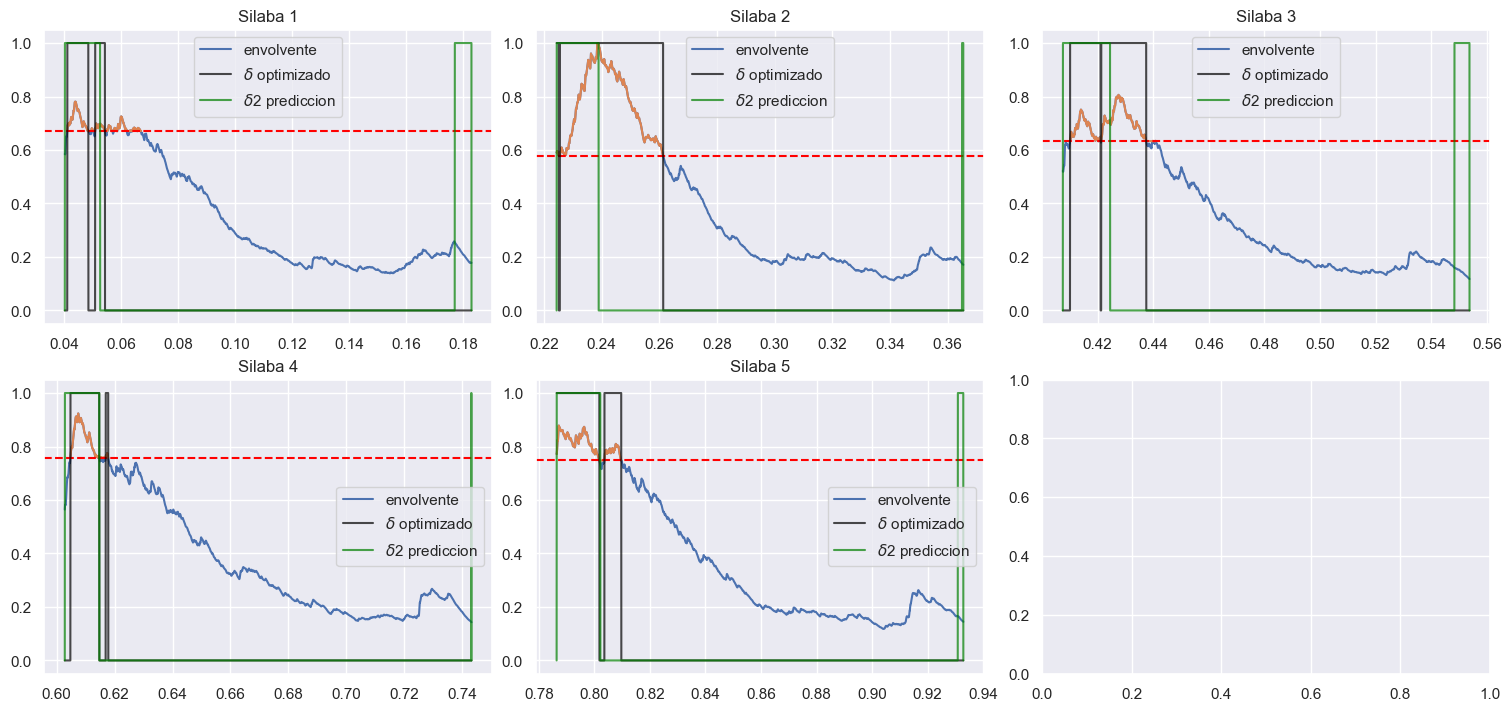

Porcentaje de solapamiento promedio sobre la predicción: 75.54077619882315 %
Porcentaje de excedente promedio sobre la optimización: 32.29419215094879 %


In [33]:
%matplotlib inline
fig, axes = plt.subplots(2, 3, figsize=(15,7), constrained_layout=True, sharey=False)
axs = axes.flatten()



delta_xs2 = np.zeros(len(t))

porcentajes_overlap = []
porcentajes_no_overlap = []
for i,ps in enumerate(ts_fon):
    t_i = ts_fon[ps]['t_i']
    t_f = ts_fon[ps]['t_f']
    t_ = t[(t >= t_i ) & (t <= t_f )]
    Xs_ = Xs[(t >= t_i ) & (t <= t_f )]/max(Xs)
    vs_ = np.abs(vs[(t >= t_i ) & (t <= t_f )])
    #delta_ = delta[(t > t_i ) & (t < t_f )]
    delta1_ = delta2[(t >= t_i ) & (t <= t_f )]
  
    #umbral para determinar delta
    umbrales = np.linspace(np.min(Xs_), np.max(Xs_), 100)
    umbral_opt, delta2_opt, score_ = encontrar_mejor_umbral(Xs_, delta1_, umbrales, min_largo=20)
    delta_xs2[(t >= t_i ) & (t <= t_f )] = delta2_opt

    #overlap
    overlap = solapamiento(delta1_ , delta2_opt)
    porcentaje_overlap = overlap/ len(delta1_[delta1_>0])
    porcentajes_overlap.append(porcentaje_overlap)
    #exceso de delta
    sobra = np.sum(delta2_opt * (1 - delta1_)) / len(delta2_opt[delta2_opt>0])
    porcentajes_no_overlap.append(sobra)
    
    axs[i].plot(t_, Xs_, label = 'envolvente')
    axs[i].plot(t_[Xs_ > umbral_opt], Xs_[Xs_ > umbral_opt])
    axs[i].axhline( umbral_opt, color = 'red', ls = '--')
    
    axs[i].plot(t_, delta2_opt, color = 'black', label = r'$\delta$ optimizado', alpha = .7)
    axs[i].plot(t_, delta1_, color = 'green', label = r'$\delta$2 prediccion', alpha = .7)
    #axs[i].plot(t_, delta_, color = 'orange', label = r'$\delta$ simulacion', alpha = .9)
    #axs[i].set_xlim(t_[0], t_[-1])
    axs[i].set_title(f'Silaba {i+1}')
    axs[i].legend()
plt.show()

print(f'Porcentaje de solapamiento promedio sobre la predicción: {np.mean(porcentajes_overlap) * 100} %')
print(f'Porcentaje de excedente promedio sobre la optimización: {np.mean(porcentajes_no_overlap) * 100} %')

In [ ]:
%matplotlib inline
plt.figure( figsize=(15,5))
#ploteo
colors = ['green','red','black','blue']

plt.plot(t, y/max(y),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t, s_m/max(s_m) ,alpha = .60, color='red', label = r'sonido')
#plt.plot(t, b, alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t, delta_xs2, alpha = .60, color=colors[2], label = r'$\delta$ optimizado')
#plt.plot(t, k/max(k), color = 'green', label = 'k')
plt.plot(t, np.abs(vs)/max(vs), alpha = .6, color = 'orange', label = 'vs')
#plt.plot(t, (delta_interp  + ruido) * f0, alpha = .6, color = colors[2], label = r'$\delta$')
plt.legend(loc=0)
#plt.xlim(0,0.35)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$y(t)$', fontsize=16)

plt.show()

In [ ]:
wavfile.write("sonido-presion/delta_opt_segmento_2.wav", fs, delta_xs2.astype(np.float32))